2017-12-07 00:00:00 2018-01-07 15:10:47.771735
bitcoin
loading https://graphs.coinmarketcap.com/currencies/bitcoin/1512576000000/1515309047771/
loading https://graphs.coinmarketcap.com/global/marketcap-total/1512576000000/1515309047771/
Populating the interactive namespace from numpy and matplotlib


/Users/Leo/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['diff']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


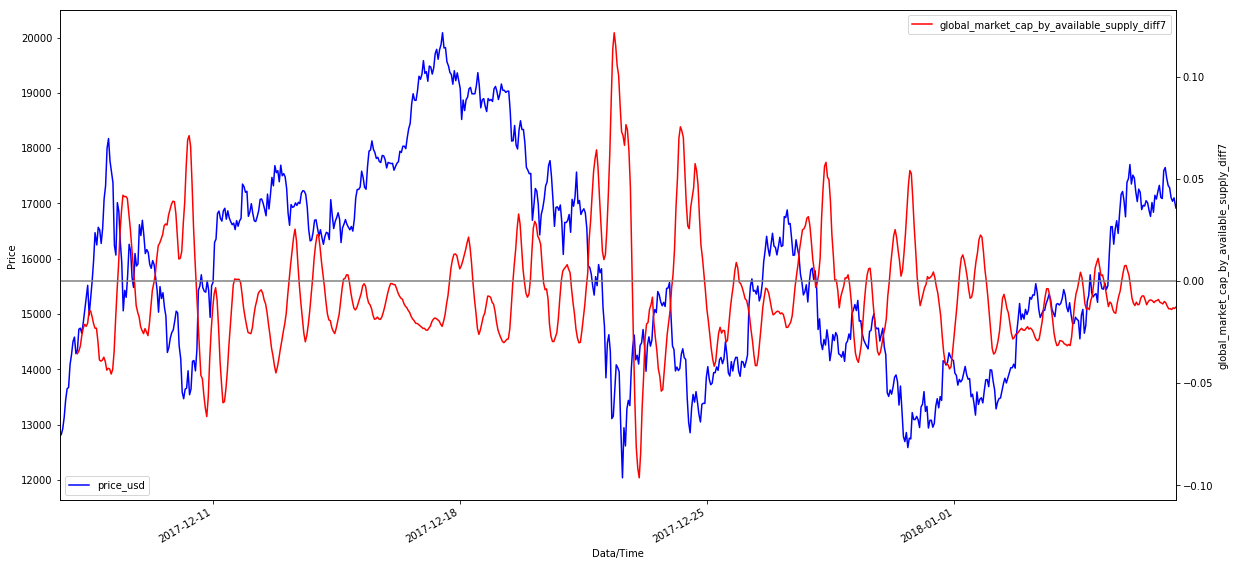

In [37]:
import requests
from bs4 import BeautifulSoup
import json
import pandas
import functools
import time
import matplotlib.pyplot as plt
import datetime


def datetime2stamp(dt):
    timestamp = int((time.mktime(dt.timetuple()) + dt.microsecond/1000000.0)*1000)
    return timestamp
    
    
dt_from = datetime.datetime(2017, 12, 7)
timestamp_from = datetime2stamp(dt_from)

dt_to = datetime.datetime.now()
timestamp_to = datetime2stamp(dt_to)


coin = 'bitcoin'
windowsize = 7
print(dt_from, dt_to)
print(coin)
daterange = (timestamp_from, timestamp_to)

def getJD(coin, daterange):
    if coin == 'global':
        requestURL = 'https://graphs.coinmarketcap.com/' + coin + '/marketcap-total/' + str(daterange[0]) + '/' + str(daterange[1]) + '/'
    else:
        requestURL = 'https://graphs.coinmarketcap.com/currencies/' + coin + '/' + str(daterange[0]) + '/' + str(daterange[1]) + '/'
    print('loading ' + requestURL)
    res = requests.get(requestURL)
    jd = json.loads(res.text)
    #print(jd.keys())
    return jd

jd = getJD(coin, daterange)
jd_global = getJD('global', daterange)


def json2df(jd, key):
    df  = pandas.DataFrame(jd[key])
    df.columns = ['datetime', key]
    df['datetime'] = pandas.to_datetime(df['datetime'], unit='ms')
    df.index = df['datetime']
    return df

def dfListMerge(dfDict):
    first = True
    for k, v in dfDict.items():
        if first:
            df = v
            first = False
        else:
            df = pandas.merge(df, v, on='datetime')
        
    return df

def getDF(jd):
    dfRaw = {}
    for key in jd:
        dfRaw[key] = json2df(jd, key)

    df = dfListMerge(dfRaw)
    return df
    
    
df = getDF(jd)

# print(df_global.head())
# exit()

#df = pandas.merge(df, df_global, on='datetime')

df.index = df['datetime']
#df['market_cap_by_available_supply_scaled'] = df['market_cap_by_available_supply'] / 1e7
df['price_usd_ma7'] = df['price_usd'].rolling(window=7).mean()

def diff(window):
    windows.append(window.copy())
    return window[-1]

df_global = getDF(jd_global)
df_global.columns = ['global_' + name if name != 'datetime' else name for name in df_global.columns]
df_global.index = df_global['datetime']
global_market_cap_rolling = df_global['global_market_cap_by_available_supply'].rolling(window=windowsize, min_periods=windowsize)

# min_global_market_cap_ma = global_market_cap_ma.min()
# max_global_market_cap_ma = global_market_cap_ma.max()
# first_global_market_cap_ma7 = global_market_cap_ma7[0]
# last_global_market_cap_ma7 = global_market_cap_ma7[-1]

global_market_cap_by_available_supply_diff = 'global_market_cap_by_available_supply_diff' + str(windowsize)

df_global[global_market_cap_by_available_supply_diff] = global_market_cap_rolling.apply(lambda x: (x[0] - x[-1]) / x[-1]).dropna()

df_global[global_market_cap_by_available_supply_diff] = df_global[global_market_cap_by_available_supply_diff].rolling(window=windowsize).mean()

fs = [20,10]

%pylab inline
ax1=df['price_usd'].plot(kind = 'line', figsize=fs, color='blue', label='price_usd')
ax1.set_xticks(df['price_usd'].values)
ax1.set_ylabel('Price')
ax1.set_xlabel('Data/Time')



field2 = global_market_cap_by_available_supply_diff #'global_market_cap_by_available_supply_diff7'#'volume_usd'
ax2=ax1.twinx()
df_global[field2].plot(kind = 'line', figsize=fs, ax = ax2, color='red', label = field2)
ax2.set_ylabel(field2)

ax1.legend(loc=3)
ax2.legend(loc=0)

# plt.axhline(y=0, color='grey', linestyle='-')
# plt.show()

fig = plt.gcf()
fig.savefig(coin + '.png')
# plt.show()
# fig = plt.figure()
# fig.savefig('plot.png')


2017-12-31 11:49:19
2018-01-07 13:04:40.730682
